# Figure 13: The probability distribution conditioned on non-extinction for the 30 mosquito model with reversion

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import sympy as sp
import itertools
from scipy.linalg import expm
import pylab as plt
import matplotlib

Importing required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_full_Q
import Finding_P_dist
import Finding_dictionary_keys
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
getQ = Finding_full_Q.getQ_Hughes
Pget = Finding_P_dist.Pget
find_keys = Finding_dictionary_keys.find_keys
F = Hughes_model.F_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Finding the coexistence steady state symbolically

In [3]:
b,nm,nw,u,v,phi,Q,d,dw,h,k = sp.symbols('b nm nw u v phi Q d dw h k')  # defining the parameters symbolically

zm = ((nm + (1-u)*nw)/(nm + nw))*(nm + (1-v)*phi*nw)
zw = v*phi*nw

# we have removed a factor nw from eq1 so the wild-type only steady state will not appear as a solution
eq1 = b*zm*sp.exp(-h*(nm+nw)**k) - d*nm   # ODE describing wild-type dynamics
eq2 = b*phi*v*sp.exp(-h*(nm+nw)**k) - dw  # Wolbachia dynamics

# change the equations to below if using alternative larval density function
#eq1 = b*zm*(1-(nm + nw)/Q) - d*nm
#eq2 = b*phi*v*(1-(nm + nw)/Q) - dw

sol_coexist = sp.solve([eq1,eq2],[nm,nw])   # solver for steady states symbolically

Parameter values

In [4]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 85/100    # Wolbachia fitness

v = 9/10      # probability of vertical transmission  ## v<1 for reversion
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k,K),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct a dictionary of all the state variables

In [5]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 30   # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}

Construct the full transition matrix

In [6]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)   # total number of states

Q = getQ(state_dict,params_dict)
print(Q)

[[-0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.12       -0.33543227  0.19388905 ...  0.          0.
   0.        ]
 [ 0.          0.24       -0.6017507  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -5.4419426   0.
   1.9619426 ]
 [ 0.          0.          0.         ...  0.12       -3.6
   0.        ]
 [ 0.          0.          0.         ...  3.6         0.
  -3.6       ]]


Finding the coexistence steady state under the given parameter values

In [7]:
# the coexistence SS correspsonds to the second solution
nm_co = sol_coexist[1][0].subs({'b':b1,'u':u,'v':v,'phi':phi,'Q':K,'d':d1,'dw':d2,'k':k,'h':h}).evalf()
nw_co = sol_coexist[1][1].subs({'b':b1,'u':u,'v':v,'phi':phi,'Q':K,'d':d1,'dw':d2,'k':k,'h':h}).evalf()
print('coexistence SS is', (nm_co,nw_co))
# we approximate the coexistence SS as (4,1)

coexistence SS is (3.82122444702620, 1.32057021331052)


Finding the probability distribution over time. This is the solution of $P'(t)=P(t)Q$ i.e. $P(t)=P(0)\exp (Qt)$.

In [8]:
import time   # import library that keeps track of how long to run code chunk
start_time = time.time()   # record start time of running code chunk

t_start = 0          # start time point calculating probability distribution over
t_range = 750       # how many days of time points
steps = t_range      # number of time points calculating over
initial_state = np.array((5,5))   # initial condition is the probability of being in state (7,1) is 1

P_vec,t = Pget(t_start,t_range,Q,steps,initial_state,state_dict)  # finds probability dist over all time points

end_time = time.time()    # record end time of running code chunk
elapsed_time = end_time - start_time   # calulate time took to run

# Print the elapsed time
print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 111.13717532157898 seconds


Save the arrays of the probability distributions and the time steps

In [9]:
np.save('prob_vec_rev.npy',P_vec) # saving the array of probability distributions
np.save('time_vec_rev.npy',t)     # saving the time points
P_vec = np.load('prob_vec_rev.npy')  # reloading P_vec

Plotting the figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


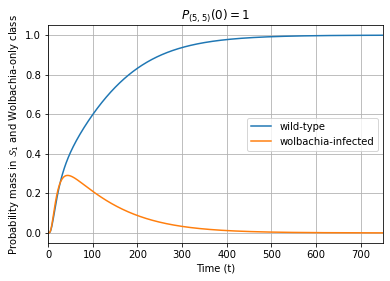

In [10]:
matplotlib.rcParams.update({'font.size': 15})   # font size
P_wild = np.zeros(steps)# initialising an array for the probability of being in the wild-type-only states over time
P_wolbachia = np.zeros(steps)  # for Wolbachia-only states
for k in range(max_pop):   # looping over wild-type/Wolbachia-only state space
    key_wild = find_keys(state_dict,np.array((k+1,0)))[0]  # finding the key for the current wild-type-only state
    P_wild += P_vec[:,key_wild]/(1-P_vec[:,0])       # adding the probability of being in that state at time t
    key_wolb = find_keys(state_dict,np.array((0,k+1)))[0]  # finding the key for the current Wolbachia-only state
    P_wolbachia += P_vec[:,key_wolb]/(1-P_vec[:,0])  # adding the probability of being in that state at time t  
    
plt.plot(t,P_wild, label = 'wild-type')  # plotting the probability of being the wild-type-only state space over t
plt.plot(t,P_wolbachia, label = 'wolbachia-infected')  # for Wolbachia-only
plt.xlim(0,750)   # take x limit
plt.legend()      # make legend
plt.xlabel('Time (t)')         # x label
plt.ylabel('Probability mass in $\mathcal{S}_1$ and Wolbachia-only class')   # y label
plt.title('$P_{(5,5)}(0)=1$')  # title
plt.grid()                     # make grid
#plt.savefig('Prob_dist_absorbing_55_dye_v09.pdf', bbox_inches='tight')  # save figure

For Figure A9 in the Appendix, change the larval density function and rerun the result.